In [15]:
import sys
import pathlib

import zarr
import asdf
import astropy.units as u
import astropy.wcs
import ndcube
import xarray
import sunpy.map
import eispac.core
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../pipeline/')
from loop_selection import interpolate_hpc_coord, straight_loop_indices

Load the loop coordinate to interpolate

In [2]:
with asdf.open('../pipeline/static/traced-loop.asdf') as af:
    traced_loop = af.tree['loop']

In [3]:
loop_width = 45 * u.arcsec

In [4]:
traced_loop_interpolate = interpolate_hpc_coord(traced_loop, 25)

### AIA

In [5]:
wavelengths = ['94', '131', '171', '193', '211', '335']

In [6]:
root = zarr.open('../pipeline/data/AIA/level_2/', mode='r')
data_arrays = {}
for w in wavelengths:
    ds = root[w]
    cube = ndcube.NDCube(
        ds[:],
        wcs=astropy.wcs.WCS(ds.attrs['wcs']),
        unit=ds.attrs['unit'],
        meta=ds.attrs['meta'],
    )
    s_parallel, s_perp, indices = straight_loop_indices(traced_loop_interpolate, loop_width, cube[0].wcs)
    straight_loop = xarray.DataArray(
        cube.data[:, indices[..., 1], indices[..., 0]],
        dims=['time', 's_parallel', 's_perp'],
        coords={
            'time': (cube.axis_world_coords(0)[0] - cube.axis_world_coords(0)[0][0]).to_value('s'),
            's_parallel': s_parallel.to_value('arcsec'),
            's_perp': s_perp.to_value('arcsec'),
        },
        attrs={**cube.meta,
               's_parallel_unit': 'arcsec',
               's_perp_unit': 'arcsec',
               'time_unit': 's'},
        name=f'straight_loop_aia_{w}',
    )
    data_arrays[w] = straight_loop
straight_loop_dataset_aia = xarray.Dataset(data_arrays)

/home/jovyan/users_conda_envs/hinode-2023-loops-poster/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/jovyan/users_conda_envs/hinode-2023-loops-poster/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 180 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/jovyan/users_conda_envs/hinode-2023-loops-poster/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 180 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [20]:
straight_loop_dataset_aia.to_netcdf('test-aia-loop-straight.nc')

In [21]:
straight_loop_dataset_aia2 = xarray.open_dataset('test-aia-loop-straight.nc')

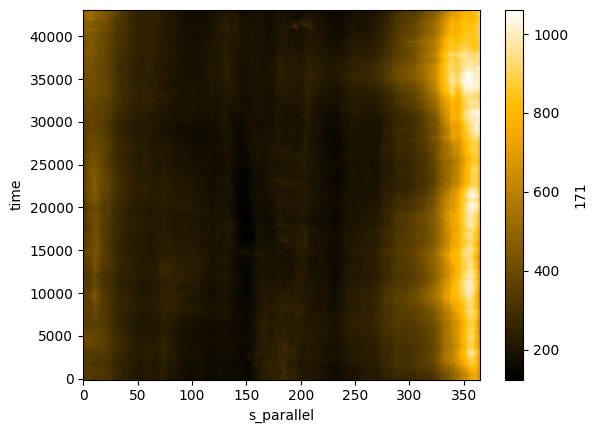

In [24]:
straight_loop_dataset_aia2['171'].mean(dim='s_perp').plot(cmap='sdoaia171')

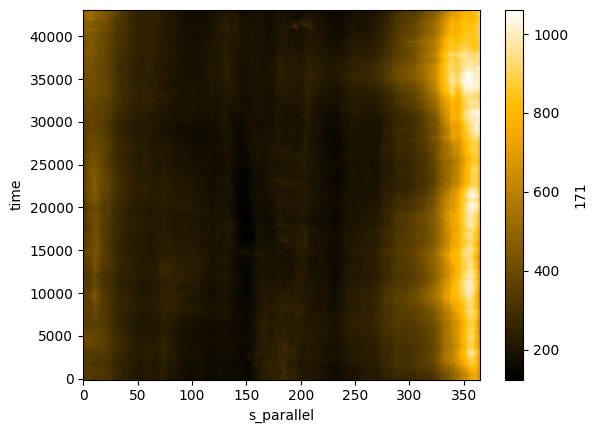

In [12]:
straight_loop_dataset_aia['171'].mean(dim='s_perp').plot(cmap='sdoaia171')

### EIS

In [13]:
eis_data_dir = pathlib.Path('../pipeline/data/EIS/level_2.5/')
eis_intensity_files = sorted(eis_data_dir.glob('*int.fits'))
eis_velocity_files = sorted(eis_data_dir.glob('*.vel.fits'))
eis_maps = sunpy.map.Map(eis_intensity_files + eis_velocity_files)
data_arrays = {}
for m in eis_maps:
    s_parallel, s_perp, indices = straight_loop_indices(traced_loop_interpolate, loop_width, m.wcs)
    straight_loop = xarray.DataArray(
        m.data[indices[..., 1], indices[..., 0]],
        dims=['s_parallel', 's_perp'],
        coords={
            's_parallel': s_parallel.to_value('arcsec'),
            's_perp': s_perp.to_value('arcsec'),
        },
        attrs={**m.meta,,
               's_parallel_unit': 'arcsec',
               's_perp_unit': 'arcsec'},
        name=f'straight_loop_eis_{m.meta["line_id"]}_{measurement}',
    )
    data_arrays[f'{m.meta["line_id"]}_{measurement}'] = straight_loop
straight_loop_dataset_eis = xarray.Dataset(data_arrays)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


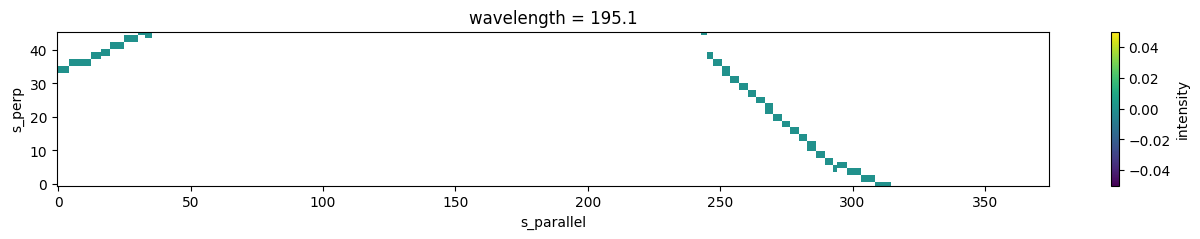

In [153]:
straight_loop_dataset_eis['intensity'].where(straight_loop_dataset_eis['intensity']==0).sel(wavelength=195.119).plot(aspect=8, size=2, x='s_parallel', y='s_perp')

Text(0, 0.5, '$s_\\perp$')

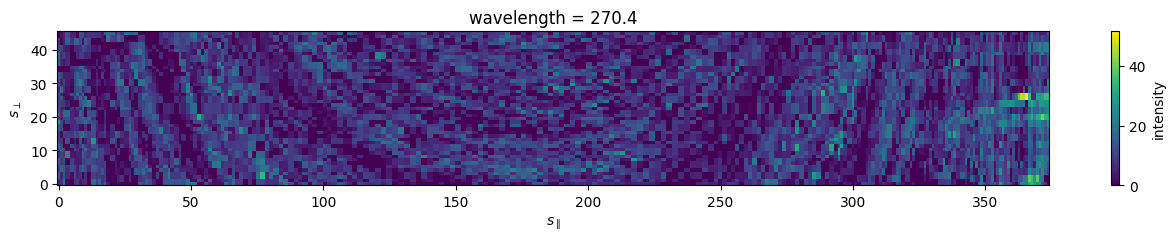

In [19]:
straight_loop_dataset_eis['intensity'].sel(wavelength=270.394).plot(aspect=8, size=2, x='s_parallel', y='s_perp')
plt.xlabel(r'$s_\parallel$')
plt.ylabel(r'$s_\perp$')

In [56]:
eis_maps.as_array().shape

(512, 180, 41)

In [61]:
np.swapaxes(eis_maps.as_array().T[np.argsort(u.Quantity([m.wavelength for m in eis_maps]))], 1, 2)

(41, 512, 180)

In [63]:
np.sort(u.Quantity([m.wavelength for m in eis_maps]))

<Quantity [180.401, 184.536, 185.213, 186.601, 186.88 , 187.964, 188.216,
           188.299, 188.497, 188.675, 188.806, 192.04 , 192.394, 192.813,
           192.858, 192.906, 193.715, 193.715, 193.874, 193.874, 194.327,
           194.396, 194.396, 195.119, 195.179, 197.862, 200.972, 201.121,
           202.044, 203.72 , 203.826, 256.686, 258.375, 262.984, 264.787,
           270.394, 270.519, 275.368, 275.665, 284.015, 284.16 ] Angstrom>

In [59]:
eis_maps[0].data.shape

(512, 180)

## Sandbox

In [20]:
from sunpy.coordinates.utils import solar_angle_equivalency
from astropy.wcs.utils import wcs_to_celestial_frame
obs = wcs_to_celestial_frame(cube_171.wcs).observer

In [21]:
s_parallel.to('Mm', equivalencies=solar_angle_equivalency(obs))

INFO: Apparent body location accounts for 500.50 seconds of light travel time [sunpy.coordinates.ephemeris]


<Quantity [  0.        ,   0.43646908,   1.05372972,   1.4901988 ,
             1.92666788,   2.36313696,   2.9803976 ,   3.41686667,
             3.85333575,   4.47059638,   4.90706545,   5.34353453,
             5.7800036 ,   6.39726423,   6.8337333 ,   7.27020236,
             7.887463  ,   8.32393206,   8.76040112,   9.37766175,
             9.81413081,  10.25059987,  10.68706893,  11.30432956,
            11.74079862,  12.17726767,  12.7945283 ,  13.23099735,
            13.84825798,  14.28472703,  14.90198766,  15.33845671,
            15.77492575,  16.39218638,  16.82865542,  17.44591605,
            17.8823851 ,  18.49964572,  18.93611476,  19.3725838 ,
            19.98984443,  20.42631347,  21.04357409,  21.48004313,
            22.09730375,  22.53377279,  23.15103341,  23.58750244,
            24.20476307,  24.6412321 ,  25.25849273,  25.87575336,
            26.31222238,  26.92948301,  27.54674364,  27.98321266,
            28.60047329,  29.03694231,  29.65420294,  30.27146

In [25]:
import distributed

In [26]:
client = distributed.Client()

In [28]:
client.scheduler.address

'tcp://127.0.0.1:44195'